# Applied Data Analysis - Impact of conflicts on African civilian population

### Abstract

The age of information makes it seem as though conflict and wars are, and always will be, ever growing part of our lives. We often feel overwhelmed by the amount and scope of information that is accessible and directed towards us, in turn rendering us indifferent to the consequences and casualties of the war.

Civilians are the greatest casualty of any war, and casualties are not always measured in body count. Civil liberties and political freedoms are and should be enjoyed by the people from all around the world, and conflicts always bring changes to freedom of expression, for better or worse.

In this project we want to focus on the continent of Africa, which we feel is underreported in the context of occurring conflicts and casualties. We will utilize UDCP dataset documenting individual events of organized violence, empowered by the Freedom House 'Freedom in the World' yearly surveys and the Human Development Index as measured by the UN.

Our goal is to produce a report with an overarching story about impacts of conflicts on the African continent in the observed period from 1990 to 2015, with the focus on civilian populations - what are the long term consequences that conflicts have on the development of the civilian population.

### Libraries

In [121]:
from bkcharts import Line, show
from bokeh.embed import file_html
from bokeh.layouts import column
from bokeh.palettes import Spectral11
from bokeh.plotting import figure, show, output_file
from bokeh.resources import CDN

import branca
import copy
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
import zipfile

%matplotlib inline

### Configuration

In [122]:
from IPython.display import IFrame, HTML
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

### Specification of regions and country names

Throughout the project, we will observe African continent through its regions as defined by [United Nations' geoscheme for Africa](https://en.wikipedia.org/wiki/United_Nations_geoscheme_for_Africa). This geoscheme is used by the UN and maintained by the UNSD department for statistical purposes, and defines five regions as follows: Northern Africa, Eastern Africa, Southern Africa, Western Africa and Central Africa. Although multiple definitions of African regions exist, depending on the observed context, we consider earlier definition as relevant and appropriate for our statistical analysis.

Furthermore, our definition of African region diverges from the official geoscheme in the following ways:
* In our analysis we have excluded overseas territories:
    * [Mayotte](https://en.wikipedia.org/wiki/Mayotte) (French overseas territory)
    * [Reunion](https://en.wikipedia.org/wiki/Réunion) (French overseas territory)
    * [Saint Helena, Ascension and Tristan da Cunha](https://en.wikipedia.org/wiki/Saint_Helena,_Ascension_and_Tristan_da_Cunha) (British overseas territory)
    
    
* In our analysis we have excluded disputed territories:
    * [Western Sahara](https://en.wikipedia.org/wiki/Western_Sahara)
    
Due to the use of several datasets from several different data sources, some countries have been referenced by different variations on their original name in different datasets. This has resulted in need to adjust names accross datasets. We have used names of countries as specified by the United Nations' geoscheme for Africa as reference accross these datasets, while adjusting any difference when needed.

In [123]:
na_countries = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan',
                'Tunisia']

ea_countries = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 
                'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique',
                'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Tanzania',
                'Uganda', 'Zambia', 'Zimbabwe']

sa_countries = ['Botswana', 'Lesotho', 'Namibia', 'South Africa', 'Swaziland']

wa_countries = ['Benin', 'Burkina Faso', 'Cabo Verde', 'Cote d\'Ivoire', 'Gambia', 
                'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali',
                'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 
                'Togo']

ca_countries = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo',
                'Equatorial Guinea', 'Gabon', 'Republic of the Congo', 'Sao Tome and Principe']

### UCDP dataset

Uppsala Conflict Data Program's georeferenced event dataset, [Global Version 17.1 (2016)](http://www.ucdp.uu.se/downloads/ged/ged171-xlsx.zip), is the central dataset used in our project. Dataset covers individual events of organized violence - phenomena of lethal violence occurring at a given time and place.

>These events are sufficiently fine-grained to be geo-coded down to the level of individual villages, with temporal durations disaggregated to single, individudal days.

There are 135,181 events present in the dataset covering the entirety of the Globe (excluding Syria), spanning from 01/01/1989 to 31/12/2016. Events are futher defined as follows:

>An incident where armed force was by an organised actor against another organized actor, or against civilians, resulting in at least 1 direct death at a specific location and a specific date.

#### Features

UDCP dataset contains many features that thoroughly document occurred events, but not all of which are utilized throughout this project. We will utilize and focus our attention on the following features:
* `year` - The year of the event.
* `type_of_violence` - Type of UCDP conflict:
    * `0` - state-based conflict
    * `1` - non-state conflict
    * `3` - one-sided violence
    
    
* `conflict_name` - Name of the UCDP conflict to which the event belongs.
* `side_a` - The name of side A in the dyad. In state-based conflicts this is always a government. In one-sided violence this is always the perpetrating party.
* `side_b` - The name of side B in the dyad. In state-based conflicts this is always the rebel movement or rivalling government. In one-sided violence this is always “civilians”.
* `country` - Name of the country in which the event took place.
* `region` - Region where the event took place.
* `best_est` - The best (most likely) estimate of total fatalities resulting from an event.

This project makes use of the events which ocurred in the African region throughout the period of 26 years (1990-2015), or roughly 35,437 events. Events documented in the dataset will be aggregated by region, and with information about Human Development Index (HDI), Political Freedom score and Civil Liberties score analyzed and visualized on per-region basis.

#### Adjustment of country names

Following names have been altered in the original UCDP dataset in order to follow earlier established country naming convention accross the project:

| Old country name      | New country name                 |
|:----------------------|:---------------------------------|
| Madagascar (Malagasy) | Madagascar                       |
| Zimbabwe (Rhodesia)   | Zimbabwe                         |
| Ivory Coast           | Cote d'Ivoire                    |
| DR Congo (Zaire)      | Democratic Republic of the Congo |
| Congo                 | Republic of the Congo            |

#### Complete documentation

Full documentation of the used dataset can be obtained [here](http://www.ucdp.uu.se/downloads/ged/ged171.pdf) for further reference.

In [124]:
def read_data():
    '''
    The repo contains the data in a zipped file to save some space,
    this function will automatically extract the csv from that zip,
    if it has not already been extracted, and return the data in a DataFrame.
    '''
    name = './data/ged171'

    # Unzip csv if not unzipped
    if not os.path.isfile(name+'.csv'):
        zip_ = zipfile.ZipFile(name+'.zip', 'r')
        zip_.extractall('./data/')
        zip_.close()

    return pd.read_csv(name+'.csv')

def adjust_country_name(name):
    result = name
    if name == 'Madagascar (Malagasy)':
        result = 'Madagascar'
    elif name == 'Zimbabwe (Rhodesia)':
        result = 'Zimbabwe'
    elif name == 'Ivory Coast':
        result = 'Cote d\'Ivoire'
    elif name == 'DR Congo (Zaire)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Congo':
        result = 'Republic of the Congo'
    return result

df = read_data()
df.country = df.country.apply(adjust_country_name)

df_na = df.loc[df.country.isin(na_countries)]
df_ea = df.loc[df.country.isin(ea_countries)]
df_sa = df.loc[df.country.isin(sa_countries)]
df_wa = df.loc[df.country.isin(wa_countries)]
df_ca = df.loc[df.country.isin(ca_countries)]

### Freedom House dataset

Freedom House is a U.S.-based U.S. Government-funded non-governmental organization (NGO) that conducts research and advocacy on democracy, political freedom, and human rights. Freedom House was founded in October 1941. Organisation describes its goal as:

> We analyze the challenges to freedom, advocate for greater political rights and civil liberties, and support frontline activists to defend human rights and promote democratic change. Founded in 1941, Freedom House was the first American organization to champion the advancement of freedom globally.

The organization's annual *Freedom in the World* report, which assesses each country's degree of political freedoms and civil liberties, is frequently cited by political scientists, journalists, and policymakers.

Organisation's reports on the state of country's political freedoms and civil liberties form our second dataset and can be obtained [here](https://freedomhouse.org/sites/default/files/FIW2017_Data.zip). We will focus our attention on the file `FH_Country_and_Territory_Ratings_and_Statuses_1972-2016.xls` which contains information about political freedom and civil liberties scores for individual countries throughout the period of 1972-2016. Moreover, we are only interested in the scores of African countries throughout the period of 1990-2015.

#### Features

Political rights and civil liberties are measured on a one-to-seven scale, with one representing the highest degree of freedom and seven the lowest. Furthermore, based on the scores assigned for political freedom and civil liberties, Freedom House then designates one of the labels: 'Free', 'Partly Free' and 'Not Free' to each country as an overarching indicator of the state of freedom in that particular country.

#### Evaluation

While there is some debate over the neutrality of Freedom House and the methodology used for the Freedom in the World report, none of the criticisms have demonstrated a systematic bias in all the ratings. For this very reason, as well as high number of citations that Freedom in the World report experiences, we have chosen to proceed with this dataset as the source of relevant indicators on the state of political and civil liberties in the observed countries. Further discussion on the evaluation and its criticism can be found [here](https://en.wikipedia.org/wiki/Freedom_in_the_World#Evaluation).

#### Missing rankings

Through the observed period, several countries have become independent, split into two or more countries, or merged with a neighboring  state. Scores for these countries are given only for the period of their existence as independent states.

#### Adjustment of country names

Following names have been altered in the original Freedom in the World dataset in order to follow earlier established country naming convention accross the project:

| Old country name    | New country name                 |
|:--------------------|:---------------------------------|
| Sao Tome & Principe | Sao Tome and Principe            |
| Congo (Brazzaville) | Republic of the Congo            |
| Congo (Kinshasa)    | Democratic Republic of the Congo |
| Gambia, The         | Gambia                           |
| Cape Verde          | Cabo Verde                       |

#### Separating relevant information

Information relevant for this project
* Political Freedoms score
* Civil liberties score
* Freedom House score

is aggregated by the year of the report. We will split this data in three respective dataframes for the easier use in the future.

In [125]:
fh_path = os.path.join('data', 'Country ratings and statuses.xlsx')
fh_data = pd.read_excel(fh_path, na_values='-')

def fh_adjust_country_name(name):
    result = name
    if name == 'Sao Tome & Principe':
        result = 'Sao Tome and Principe'
    elif name == 'Congo (Brazzaville)':
        result = 'Republic of the Congo'
    elif name == 'Congo (Kinshasa)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Gambia, The':
        result = 'Gambia'
    elif name == 'Cape Verde':
        result = 'Cabo Verde'
    return result

fh_data = fh_data.drop(fh_data.columns[1:52], axis=1)
fh_data = fh_data.iloc[2:]
fh_data[fh_data.columns[0]] = fh_data[fh_data.columns[0]].apply(fh_adjust_country_name)

political_rights = pd.DataFrame()
political_rights['Country'] = fh_data[fh_data.columns[0]]
pr_index = 1 + 0

civil_liberties = pd.DataFrame()
civil_liberties['Country'] = fh_data[fh_data.columns[0]]
cl_index = 1 + 1

fh_status = pd.DataFrame()
fh_status['Country'] = fh_data[fh_data.columns[0]]
fhs_index = 1 + 2

year = 1990

for i in range(26):
    political_rights[year] = fh_data[fh_data.columns[pr_index]]
    civil_liberties[year] = fh_data[fh_data.columns[cl_index]]
    fh_status[year] = fh_data[fh_data.columns[fhs_index]]
    
    pr_index += 3
    cl_index += 3
    fhs_index += 3
    year += 1
    
# Divide by region on political freedoms
political_rights_na = political_rights[political_rights['Country'].isin(na_countries)]
political_rights_ea = political_rights[political_rights['Country'].isin(ea_countries)]
political_rights_sa = political_rights[political_rights['Country'].isin(sa_countries)]
political_rights_wa = political_rights[political_rights['Country'].isin(wa_countries)]
political_rights_ca = political_rights[political_rights['Country'].isin(ca_countries)]

# Divide by region on civil liberties
civil_liberties_na =  civil_liberties[civil_liberties['Country'].isin(na_countries)]
civil_liberties_ea =  civil_liberties[civil_liberties['Country'].isin(ea_countries)]
civil_liberties_sa =  civil_liberties[civil_liberties['Country'].isin(sa_countries)]
civil_liberties_wa =  civil_liberties[civil_liberties['Country'].isin(wa_countries)]
civil_liberties_ca =  civil_liberties[civil_liberties['Country'].isin(ca_countries)]

# Divide by region on Freedom House's score
fh_status_na =  fh_status[fh_status['Country'].isin(na_countries)]
fh_status_ea =  fh_status[fh_status['Country'].isin(ea_countries)]
fh_status_sa =  fh_status[fh_status['Country'].isin(sa_countries)]
fh_status_wa =  fh_status[fh_status['Country'].isin(wa_countries)]
fh_status_ca =  fh_status[fh_status['Country'].isin(ca_countries)]

### Human Development Index dataset

The Human Development Index (HDI) is a composite statistic (composite index) of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores higher HDI when the lifespan is higher, the education level is higher, and the GDP per capita is higher.

>The origins of the HDI are found in the annual Human Development Reports produced by the Human Development Reports Office of the United Nations Development Programme (UNDP). These were devised and launched by Pakistani economist Mahbub ul Haq in 1990, and had the explicit purpose "to shift the focus of development economics from national income accounting to people-centered policies".

Our final dataset is Human Development report by the UN that includes calculated Human Development Indices for the years 1990 through 2015. Naturally, we are interested in the values associated countries from the African continent.

Human Development Index obtains value in the range [0,1], 1 being best possible value.

#### Missing rankings

Through the observed period, several countries have become independent, split into two or more countries, or merged with a neighboring  state. Scores for these countries are given only for the period of their existence as independent states.

#### Adjustment of country names

Following names have been altered in the original Human Development Index dataset in order to follow earlier established country naming convention accross the project:

| Old country name                   | New country name                 |
|:-----------------------------------|:---------------------------------|
| Congo (Democratic Republic of the) | Democratic Republic of the Congo |
| Congo                              | Republic of the Congo            |
| Tanzania (United Republic of)      | Tanzania                         |

In [126]:
hdi_path = os.path.join('data','Human Development Index (HDI).csv')
hdi_data = pd.read_csv(hdi_path, skiprows=1)
hdi_data = hdi_data.drop(['HDI Rank (2015)'], axis=1)

def hdi_adjust_country_name(name):
    result = name
    if name == 'Congo (Democratic Republic of the)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Congo':
        result = 'Republic of the Congo'
    elif name == 'Tanzania (United Republic of)':
        result = 'Tanzania'
    return result

hdi_data.Country = hdi_data.Country.apply(lambda x: hdi_adjust_country_name(x.strip()))

hdi_na = hdi_data[hdi_data['Country'].isin(na_countries)]
hdi_ea = hdi_data[hdi_data['Country'].isin(ea_countries)]
hdi_sa = hdi_data[hdi_data['Country'].isin(sa_countries)]
hdi_wa = hdi_data[hdi_data['Country'].isin(wa_countries)]
hdi_ca = hdi_data[hdi_data['Country'].isin(ca_countries)]

hdi_ea.loc[len(hdi_ea)] = ['Somalia' if i == 0 else np.nan for i in range(len(hdi_ea.columns))]

### Map data

Map visualizations throughout the project make use of the `africa.json` file which maps African countries, available under MIT license by the author [David Eldersveld](https://github.com/deldersveld/topojson/blob/master/continents/africa.json). We have performed several modifications to the original file in order to adjust country names to follow naming convention used throughout this project:

| Old country name  | New country name      |
|:------------------|:----------------------|
| Cape Verde        | Cabo Verde            |
| Ivory Coast       | Code d'Ivoire         |
| Guinea Bissau     | Guinea-Bissau         |
| Republic of Congo | Republic of the Congo |

Furthermore, we have not been able to properly display countries Mauritius and Seychelles with our working version of topojson file. For this reason, aforementioned countries have been omitted in the map visualizations, and will be added at a later date.

In [127]:
africa_geo_path = os.path.join('topojson', 'africa.json')
africa_geo_data = json.load(open(africa_geo_path))

def map_path(map_name):
    return os.path.join('maps', map_name)

def save_map(map_, map_name):
    map_.save(map_path(map_name))

### Overview of the data analysis pipeline

The goal of our report is to constructively and competently collect, filter, analyze and present the data in a way that allows for supported and reasonable conclusions to be made. We want to lay the groundwork for any future review or research that relies on this report or its findings, as we believe that future studies could enrich any findings through the addition of more relevant data.

Our report applies same analytical tools and provides descriptive commentary for each African region separately. The goal of this approach is to compartmentalize analysis and try to infer trends that may occur due to geographical proximity between nations, as well as their cultural similarities and differences. The time period from which this report pulls and analyses data encompasses years from 1990 to 2015.

Analytical treatment of each region begins with a depiction of average number of occurrences and average number of casualties for violent events that have occurred in the region, broken down by the type of violent event that took place. The analysis continues with the plot of the average scores region has received for political rights and civil liberties throughout the observed years, as well as an average Human Development Index for the region. Finally, the correlation between said values is tested via Spearman’s correlation test.

Averaging values for different metrics across countries in one region, while unbiased, lowers robustness of certain findings since results can be heavily skewed due to outliers, e.g. casualties stemming from Rwandan genocide in 1994 heavily influence casualties for Eastern African region as a whole in the same observed period. For this reason, each region will be accompanied by two interactive maps that provide detailed information about each country’s statistics regarding violent events (count and casualties), and indicators (political rights and civil liberties score, Human Development Index).

Lastly, this report will include one case study where we will dive deeper into the analysis of Zimbabwe’s trends throughout the observed period, further extended with the information about countries greater socioeconomic and political context which we believe influenced said  trends. The goal of this case study is double-natured since it allows for observation of country-specific trends through greater regional context, as well as showcases opportunities for extension of current research through deeper analysis on country level.

### Utility dictionaries

In [128]:
region_countries_dict = {
    'na': na_countries,
    'ea': ea_countries,
    'sa': sa_countries,
    'wa': wa_countries,
    'ca': ca_countries
}

region_center_dict = {
    'na': [22.989358, 11.861105],
    'ea': [-3.967289, 43.487203],
    'sa': [-25.734728, 24.919672],
    'wa': [16.155142, -3.864663],
    'ca': [4.322669, 19.261304]
}

conflict_region_dict = { 
    'na': df_na,
    'ea': df_ea,
    'sa': df_sa,
    'wa': df_wa,
    'ca': df_ca
}

hdi_region_dict = {
    'na': hdi_na,
    'ea': hdi_ea,
    'sa': hdi_sa,
    'wa': hdi_wa,
    'ca': hdi_ca
}

pr_region_dict = {
    'na': political_rights_na,
    'ea': political_rights_ea,
    'sa': political_rights_sa,
    'wa': political_rights_wa,
    'ca': political_rights_ca
}

cl_region_dict = {
    'na': civil_liberties_na,
    'ea': civil_liberties_ea,
    'sa': civil_liberties_sa,
    'wa': civil_liberties_wa,
    'ca': civil_liberties_ca
}

### Utility functions

#### Function for country information filtering and grouping

In [129]:
def country_conflict_distribution(country, region={'na', 'ea', 'sa', 'wa', 'ca'}):
    cc_data = conflict_region_dict[region]
        
    cc_data = cc_data[cc_data.country == country] \
        .groupby(['year', 'type_of_violence']) \
        .agg('count') \
        .reset_index() \
        .set_index('year')
    
    cc_data = cc_data[(cc_data.index >= 1990) & (cc_data.index <= 2015)].fillna(0)
    
    cc_data = cc_data[['type_of_violence','id']]
    cc_data.columns = ['Type of violence', 'Count']
    return cc_data

def country_conflict_casualties(country, region={'na', 'ea', 'sa', 'wa', 'ca'}):
    cc_data = conflict_region_dict[region]
    
    cc_data = cc_data[cc_data.country == country] \
        .groupby(['year', 'type_of_violence']) \
        .sum() \
        .reset_index() \
        .set_index('year')
        
    cc_data = cc_data[(cc_data.index >= 1990) & (cc_data.index <= 2015)].fillna(0)
    
    cc_data = cc_data[['type_of_violence','best']]
    cc_data.columns = ['Type of violence', 'Number of casualties']
    return cc_data

def country_conflicts(country, region={'na', 'ea', 'sa', 'wa', 'ca'}):
    ccd_data = country_conflict_distribution(country, region)
    ccd_data['Year'] = ccd_data.index
    
    ccc_data = country_conflict_casualties(country, region)
    ccc_data['Year'] = ccc_data.index
    
    if ccd_data.empty and ccc_data.empty:
        smt = pd.DataFrame({'Year': [], 'Type of violence': [], 'Count': [], 'Number of casualties': []})
        smt = smt.set_index('Year')
        return smt
    
    df = ccd_data.merge(ccc_data, how='outer', on=['Year', 'Type of violence'])
    df = df.set_index('Year')
    return df

def country_indicator(country, region_data, indicator_name):
    df = region_data[region_data.Country == country]
    df = df.transpose()
    df = df.drop(['Country'], axis=0)
    df.index = df.index.astype(int)
    df.columns = [indicator_name]
    return df

def country_hdi(country, region={'na','ea','sa','wa','ca'}):
    r_hdi = hdi_region_dict[region]
    return country_indicator(country, r_hdi, 'HDI')

def country_pr(country, region={'na','ea','sa','wa','ca'}):
    r_pr = pr_region_dict[region]
    return country_indicator(country, r_pr, 'Political rights score')

def country_cl(country, region={'na','ea','sa','wa','ca'}):
    r_cl = cl_region_dict[region]
    return country_indicator(country, r_cl, 'Civil liberties score')

def country_indicators(country, region={'na','ea','sa','wa','ca'}):
    c_hdi = country_hdi(country, region)
    c_pr = country_pr(country, region)
    c_cl = country_cl(country, region)
    
    return c_hdi.join([c_pr, c_cl], how='inner')

#### Functions for region information filtering and grouping

In [130]:
def region_conflict_distribution(region={'na', 'ea', 'sa', 'wa', 'ca'}):
    cc_data = conflict_region_dict[region]
        
    cc_data = cc_data.groupby(['year', 'type_of_violence']) \
        .agg('count') \
        .reset_index() \
        .set_index('year')
    
    cc_data = cc_data[(cc_data.index >= 1990) & (cc_data.index <= 2015)].fillna(0)
    
    cc_data = cc_data[['type_of_violence','id']]
    cc_data.columns = ['Type of violence', 'Count']
    return cc_data

def region_conflict_casualties(region={'na', 'ea', 'sa', 'wa', 'ca'}):
    cc_data = conflict_region_dict[region]
        
    cc_data = cc_data.groupby(['year', 'type_of_violence']) \
        .sum() \
        .reset_index() \
        .set_index('year')
    
    cc_data = cc_data[(cc_data.index >= 1990) & (cc_data.index <= 2015)].fillna(0)
    
    cc_data = cc_data[['type_of_violence','best']]
    cc_data.columns = ['Type of violence', 'Number of casualties']
    return cc_data

def region_conflicts(region={'na', 'ea', 'sa', 'wa', 'ca'}):
    rcd_data = region_conflict_distribution(region)
    rcd_data['Year'] = rcd_data.index
    
    rcc_data = region_conflict_casualties(region)
    rcc_data['Year'] = rcc_data.index
    
    df = rcd_data.merge(rcc_data, how='outer', on=['Year', 'Type of violence'])
    df = df.set_index('Year')
    return df

def region_indicator(data, indicator_name):
    df = copy.deepcopy(data)
    df = df.transpose()
    df = df.drop(['Country'], axis=0)
    df.index = df.index.astype(int)
    df[indicator_name] = df.mean(axis=1)
    df = df.drop(df.columns[0:len(df.columns)-1], axis=1)
    return df

def region_hdi(region={'na','ea','sa','wa','ca'}):
    return region_indicator(hdi_region_dict[region], 'HDI')

def region_pr(region={'na','ea','sa','wa','ca'}):
    return region_indicator(pr_region_dict[region], 'Political rights score')

def region_cl(region={'na','ea','sa','wa','ca'}):
    return region_indicator(cl_region_dict[region], 'Civil liberties score')

def region_indicators(region={'na','ea','sa','wa','ca'}):
    r_hdi = region_hdi(region)
    r_pr = region_pr(region)
    r_cl = region_cl(region)
    
    df = r_hdi.join([r_pr, r_cl], how='inner')
    return df

def region_correlation_data(region={'na','ea','sa','wa','ca'}):
    rcd_data = region_conflict_distribution(region)
    ri_data = region_indicators(region)
    
    tov1 = rcd_data[rcd_data['Type of violence'] == 1]
    tov1 = tov1[['Count']]
    tov1.columns = ['Type of violence 1']
    
    tov2 = rcd_data[rcd_data['Type of violence'] == 2]
    tov2 = tov2[['Count']]
    tov2.columns = ['Type of violence 2']
    
    tov3 = rcd_data[rcd_data['Type of violence'] == 3]
    tov3 = tov3[['Count']]
    tov3.columns = ['Type of violence 3']
    
    df = tov1.join([tov2, tov3, ri_data], how='outer').fillna(0)
    return df

#### Functions for plotting

In [131]:
def plot_conflicts(conflicts):
    f, (ax1, ax2) = plt.subplots(2, figsize=(16,8))
    
    sns.pointplot(x=conflicts.index, y='Count', hue='Type of violence', data=conflicts, ax=ax1)
    sns.pointplot(x=conflicts.index, y='Number of casualties', hue='Type of violence', data=conflicts, ax=ax2)
        
    ax1.set(title='Number of occurrences per type of violent event', xlabel='Year', ylabel='Count')
    ax2.set(title='Number of causalties per type of violent event', xlabel='Year', ylabel='Casualties')
    
    plt.tight_layout()

def plot_indicators(indicators):
    f, (ax, ax3) = plt.subplots(2, figsize=(16,8))

    ax2 = ax.twinx()
    sns.pointplot(x=indicators.index, y='Political rights score', data=indicators, color='red', ax=ax)
    sns.pointplot(x=indicators.index, y='Civil liberties score', data=indicators, color='blue', ax=ax2)
    sns.pointplot(x=indicators.index, y='HDI', data=indicators, color='green', ax=ax3)

    ax.set_title('Political rights and civil liberties')
    ax3.set_title('Human development index')
    
    ax.legend(['Political rights score'], loc='upper right', bbox_to_anchor=(1, 1))
    ax2.legend(['Civil liberties score'], loc='upper right', bbox_to_anchor=(1, 0.9))
    ax3.legend(['Human development index'], loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
def plot_correlation(data):
    f, ax = plt.subplots(figsize=(7,5))
    
    corr = data.corr(method='spearman')
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", ax=ax)
    ax.set_title('Correlation heatmap')

#### Functions for plotting popups

In [132]:
from bokeh.models import NumeralTickFormatter
from math import pi

def plot_conflicts_popup(conflicts, country_name):
    f1 = figure(width=500, height=300)
    
    tov1 = conflicts[conflicts['Type of violence'] == 1]
    tov2 = conflicts[conflicts['Type of violence'] == 2]
    tov3 = conflicts[conflicts['Type of violence'] == 3]
    
    min_year = min(conflicts.index)
    max_year = max(conflicts.index)
    
    f1.line(tov1.index, tov1['Count'], legend='Type of violence 1', color='red')
    f1.circle(tov1.index, tov1['Count'], color='red')
    f1.line(tov2.index, tov2['Count'], legend='Type of violence 2', color='blue')
    f1.circle(tov2.index, tov2['Count'], color='blue')
    f1.line(tov3.index, tov3['Count'], legend='Type of violence 3', color='green')
    f1.circle(tov3.index, tov3['Count'], color='green')
    
    f1.toolbar.disabled = True
    f1.toolbar.logo = None
    f1.toolbar_location = None
    f1.title.text = 'Number of occurrences per type of violent event for ' + country_name
    f1.xaxis.axis_label = 'Year'
    f1.yaxis.axis_label = 'Count'
    f1.axis.axis_label_text_font_size = '10pt'
    f1.title.align = 'center'
    f1.title.text_font_size = '12pt'
    f1.xaxis.major_label_text_font_size = '10pt'
    f1.xaxis.ticker = list(range(min_year, max_year + 1))
    f1.xaxis.major_label_orientation = pi/2
    f1.legend.location = 'top_right'
    f1.legend.border_line_width = 0
    f1.legend.background_fill_alpha = 0.0
    
    f2 = figure(width=500, height=300)
    
    f2.line(tov1.index, tov1['Number of casualties'], legend='Type of violence 1', color='red')
    f2.circle(tov1.index, tov1['Number of casualties'], color='red')
    f2.line(tov2.index, tov2['Number of casualties'], legend='Type of violence 2', color='blue')
    f2.circle(tov2.index, tov2['Number of casualties'], color='blue')
    f2.line(tov3.index, tov3['Number of casualties'], legend='Type of violence 3', color='green')
    f2.circle(tov3.index, tov3['Number of casualties'], color='green')
    
    f2.toolbar.disabled = True
    f2.toolbar.logo = None
    f2.toolbar_location = None
    f2.title.text = 'Number of casualties per type of violent event for ' + country_name
    f2.xaxis.axis_label = 'Year'
    f2.yaxis.axis_label = 'Number of casualties'
    f2.axis.axis_label_text_font_size = '10pt'
    f2.title.align = 'center'
    f2.title.text_font_size = '12pt'
    f2.xaxis.major_label_text_font_size = '10pt'
    f2.xaxis.ticker = list(range(min_year, max_year + 1))
    f2.xaxis.major_label_orientation = pi/2
    f2.legend.location = 'top_right'
    f2.legend.border_line_width = 0
    f2.legend.background_fill_alpha = 0.0
        
    return column(f1, f2)

def conflicts_popup_html(conflicts, country_name):
    if conflicts.empty:
        html = r'<h4>No conflict information to display for ' + country_name + '</h4>'
    else:
        p = plot_conflicts_popup(conflicts, country_name)
        html = file_html(p, CDN, country_name + '_conflicts_popup')
    return branca.element.IFrame(html=html, width=540, height=300)

def plot_indicators_popup(indicators, country_name):
    min_year = min(indicators.index)
    max_year = max(indicators.index)
    
    f1 = figure(width=500, height=300)
    f1.line(indicators.index, indicators['Political rights score'], legend='Political rights score', color='red')
    f1.line(indicators.index, indicators['Civil liberties score'], legend='Civil liberties score', color='blue')
    f1.toolbar.disabled = True
    f1.toolbar.logo = None
    f1.toolbar_location = None
    f1.title.text = 'Political rights and civil liberties score for ' + country_name
    f1.xaxis.axis_label = 'Year'
    f1.yaxis.axis_label = 'Score'
    f1.axis.axis_label_text_font_size = '10pt'
    f1.xaxis.ticker = list(range(min_year, max_year + 1))
    f1.xaxis.major_label_orientation = pi/2
    f1.title.align = 'center'
    f1.title.text_font_size = '12pt'
    f1.xaxis.major_label_text_font_size = '10pt'
    f1.height = 380
    f1.width = 500
    f1.legend.location = 'bottom_right'
    f1.legend.border_line_width = 0
    f1.legend.background_fill_alpha = 0.0
    
    if indicators.HDI.isnull().all():
        return f1
    
    f2 = figure(width=500, height=300)
    f2.line(indicators.index, indicators['HDI'], color='green')
    f2.toolbar.disabled = True
    f2.toolbar.logo = None
    f2.toolbar_location = None
    f2.title.text = 'Human development index of ' + country_name
    f2.xaxis.axis_label = 'Year'
    f2.yaxis.axis_label = 'HDI'
    f2.axis.axis_label_text_font_size = '10pt'
    f2.xaxis.ticker = list(range(min_year, max_year + 1))
    f2.xaxis.major_label_orientation = pi/2
    f2.title.align = 'center'
    f2.title.text_font_size = '12pt'
    f2.xaxis.major_label_text_font_size = '10pt'
    f2.height = 380
    f2.width = 500
    
    return column(f1, f2)

def indicators_popup_html(indicators, country_name):
    if indicators.empty:
        html = r'<h4>No indicator information to display for ' + country_name + '</h4>'
    else:
        p = plot_indicators_popup(indicators, country_name)
        html = file_html(p, CDN, country_name + '_indicators_popup')
    return branca.element.IFrame(html=html, width=540, height=300)

#### Functions for embedding popups

In [133]:
def extract_countries(countries):
    new_countries = []
    
    for country_json in africa_geo_data['objects']['continent_Africa_subunits']['geometries']:
        if country_json['properties']['geounit'] in countries:
            new_country_json = copy.deepcopy(africa_geo_data)
            new_country_json['objects']['continent_Africa_subunits']['geometries'] = [country_json]
            new_countries.append(new_country_json)
            
    return new_countries

def map_data_per_country(country_function, region={'na','ea','sa','wa','ca'}, fill_color='#ff6e3a', border_color='#ff5439'):
    center = region_center_dict[region]
    countries = region_countries_dict[region]
    africa = folium.Map(center, tiles='cartodbpositron', zoom_start=4)
    countries_topojsons = extract_countries(countries)
    
    for country in countries_topojsons:
        name = country['objects']['continent_Africa_subunits']['geometries'][0]['properties']['geounit']
        
        tj = folium.TopoJson(
            country,
            'objects.continent_Africa_subunits', 
            style_function = lambda feature: {
                'fillColor' : fill_color,
                'fillOpacity' : 0.8,
                'color' : border_color,
                'weight' : 1
            })
        
        country_iframe = country_function(name)
        popup = folium.Popup(country_iframe, max_width=540)

        tj.add_child(popup)
        tj.add_to(africa)
        
    return africa

def map_conflicts_per_country(region={'na','ea','sa','wa','ca'}):
    return map_data_per_country(
        lambda x: conflicts_popup_html(country_conflicts(x, region), x), 
        region
    )
    
def map_indicators_per_country(region={'na','ea','sa','wa','ca'}):
    return map_data_per_country(
        lambda x: indicators_popup_html(country_indicators(x, region), x),
        region
    )

## North Africa

#### Plots

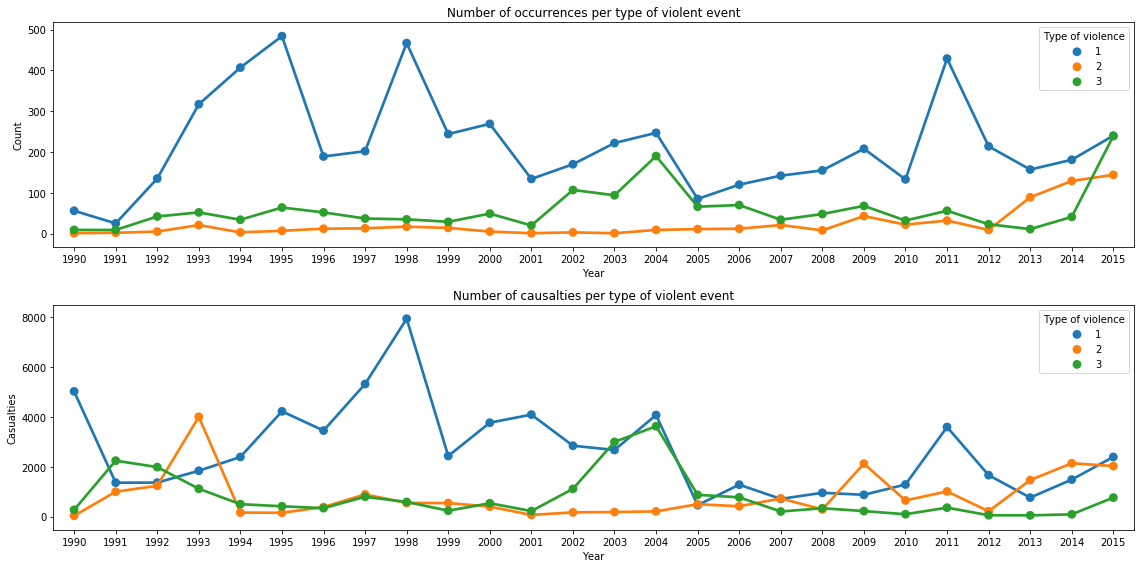

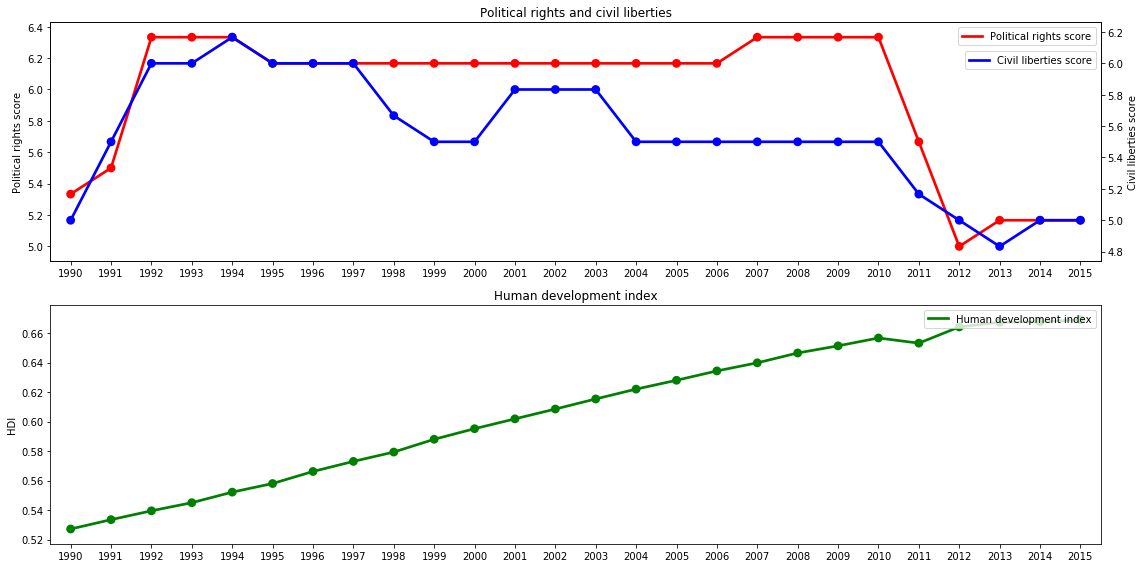

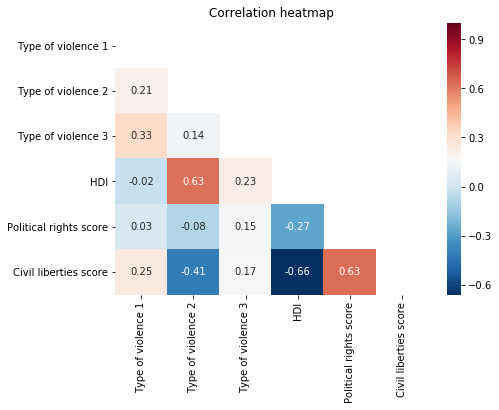

In [134]:
na_conflicts = region_conflicts('na')
na_indicators = region_indicators('na')
na_correlation_data = region_correlation_data('na')

plot_conflicts(na_conflicts)
plot_indicators(na_indicators)
plot_correlation(na_correlation_data)

#### Maps

In [135]:
na_conflicts_map = map_conflicts_per_country('na')
na_indicators_map = map_indicators_per_country('na')

save_map(na_conflicts_map, 'na_conflicts.html')
save_map(na_indicators_map, 'na_indicators.html')

IFrame(src=map_path('na_conflicts.html'), width=900, height=500)
IFrame(src=map_path('na_indicators.html'), width=900, height=500)

## East Africa

#### Plots

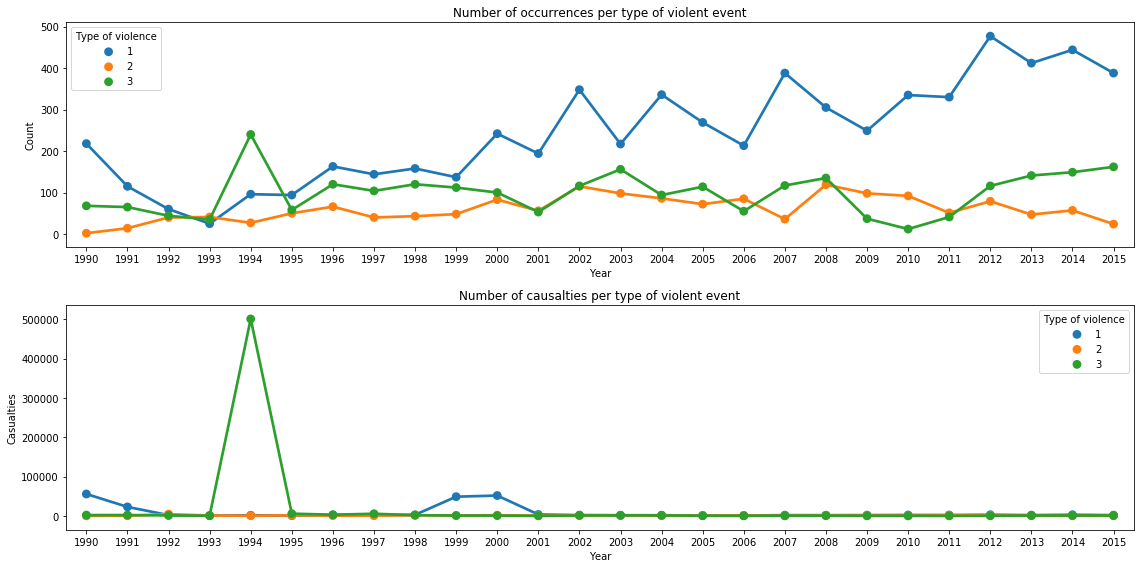

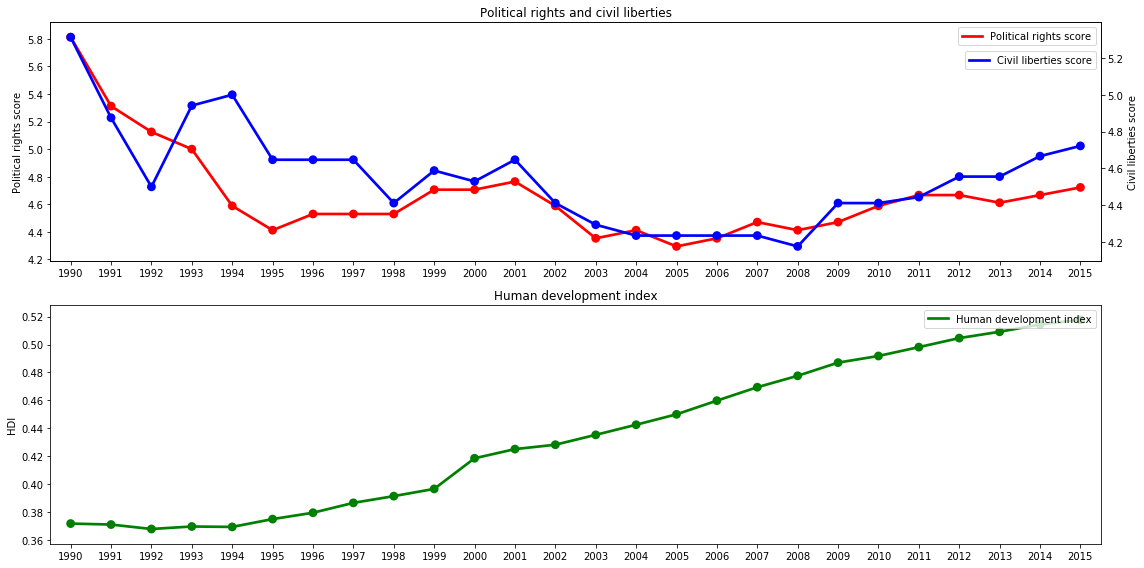

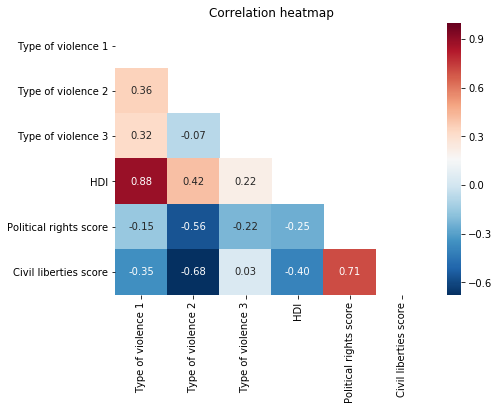

In [136]:
ea_conflicts = region_conflicts('ea')
ea_indicators = region_indicators('ea')
ea_correlation_data = region_correlation_data('ea')

plot_conflicts(ea_conflicts)
plot_indicators(ea_indicators)
plot_correlation(ea_correlation_data)

#### Maps

In [137]:
ea_conflicts_map = map_conflicts_per_country('ea')
ea_indicators_map = map_indicators_per_country('ea')

save_map(ea_conflicts_map, 'ea_conflicts.html')
save_map(ea_indicators_map, 'ea_indicators.html')

IFrame(src=map_path('ea_conflicts.html'), width=900, height=500)
IFrame(src=map_path('ea_indicators.html'), width=900, height=500)

## South Africa

#### Plots

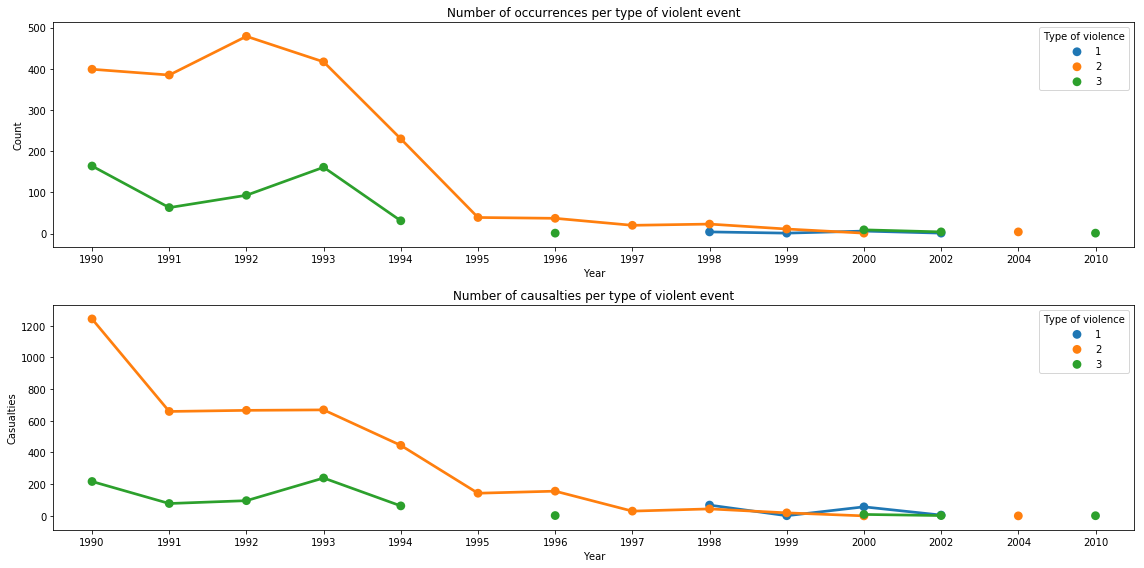

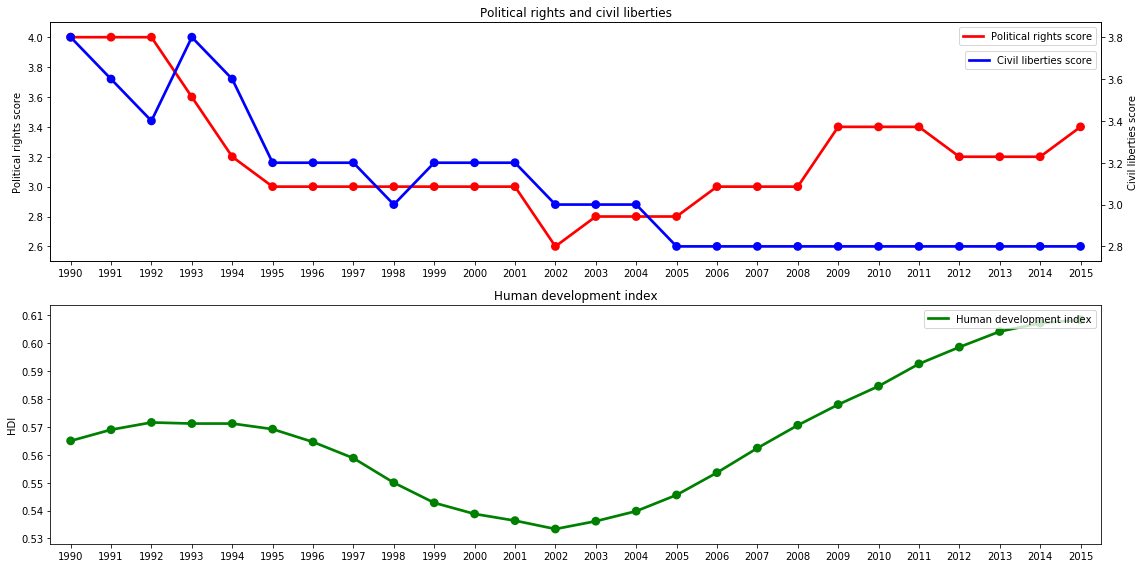

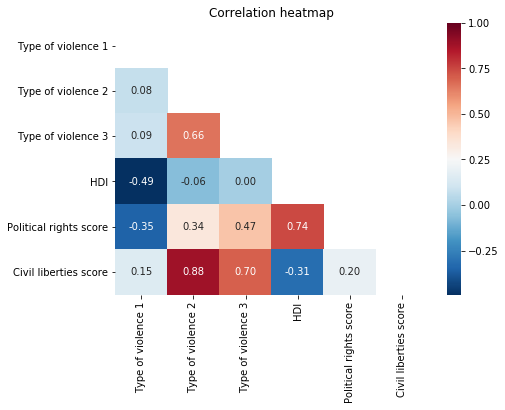

In [138]:
sa_conflicts = region_conflicts('sa')
sa_indicators = region_indicators('sa')
sa_correlation_data = region_correlation_data('sa')

plot_conflicts(sa_conflicts)
plot_indicators(sa_indicators)
plot_correlation(sa_correlation_data)

#### Maps

In [139]:
sa_conflicts_map = map_conflicts_per_country('sa')
sa_indicators_map = map_indicators_per_country('sa')

save_map(sa_conflicts_map, 'sa_conflicts.html')
save_map(sa_indicators_map, 'sa_indicators.html')

IFrame(src=map_path('sa_conflicts.html'), width=900, height=500)
IFrame(src=map_path('sa_indicators.html'), width=900, height=500)

## West Africa

#### Plots

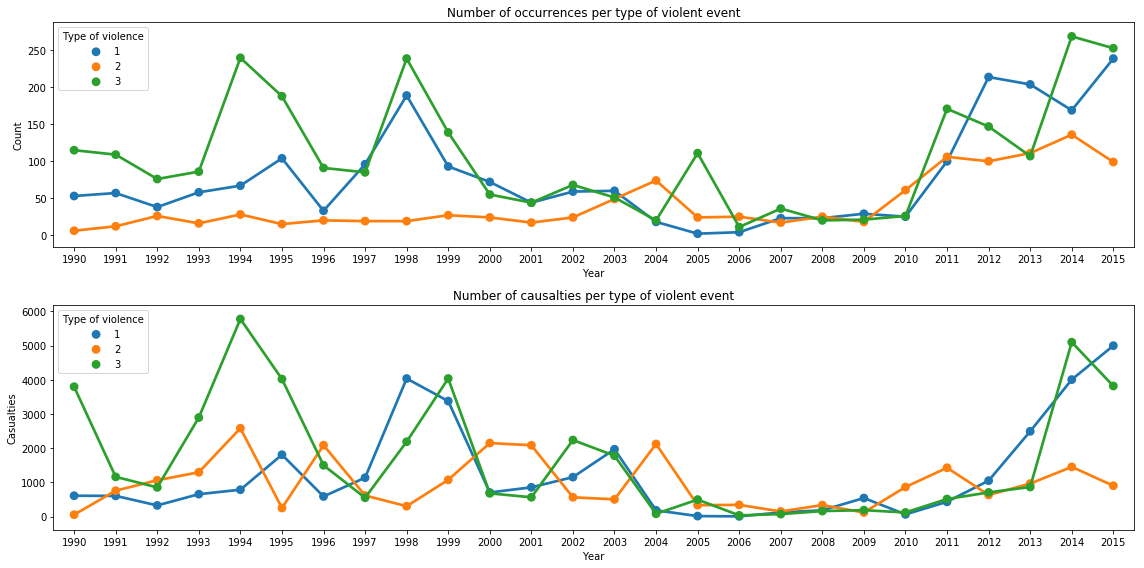

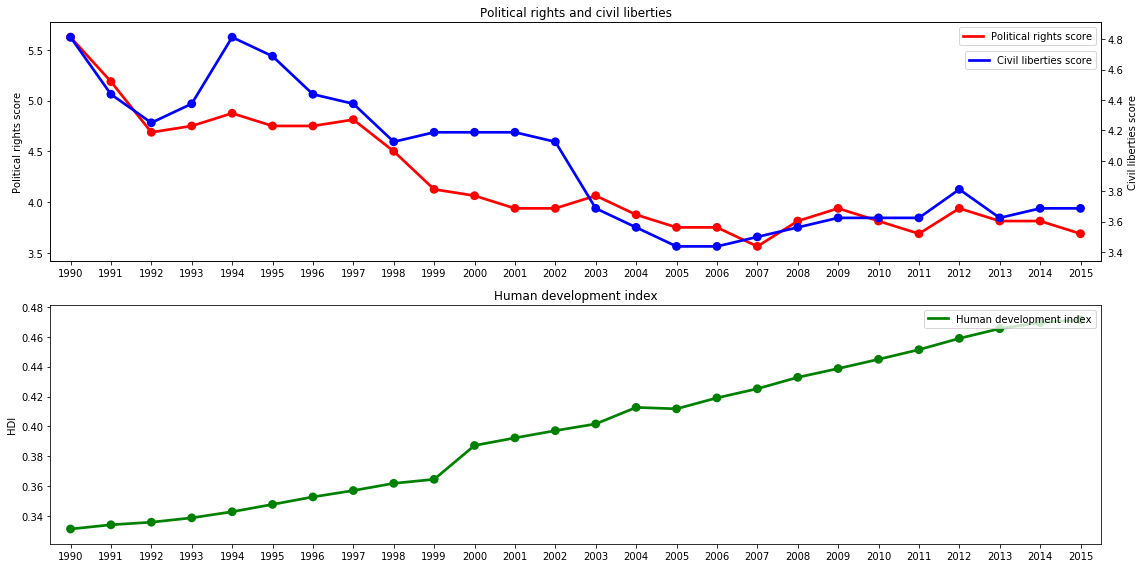

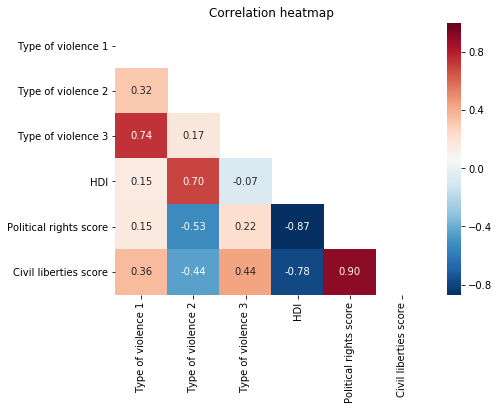

In [140]:
wa_conflicts = region_conflicts('wa')
wa_indicators = region_indicators('wa')
wa_correlation_data = region_correlation_data('wa')

plot_conflicts(wa_conflicts)
plot_indicators(wa_indicators)
plot_correlation(wa_correlation_data)

#### Maps

In [141]:
wa_conflicts_map = map_conflicts_per_country('wa')
wa_indicators_map = map_indicators_per_country('wa')

save_map(wa_conflicts_map, 'wa_conflicts.html')
save_map(wa_indicators_map, 'wa_indicators.html')

IFrame(src=map_path('wa_conflicts.html'), width=900, height=500)
IFrame(src=map_path('wa_indicators.html'), width=900, height=500)

## Central Africa

#### Plots

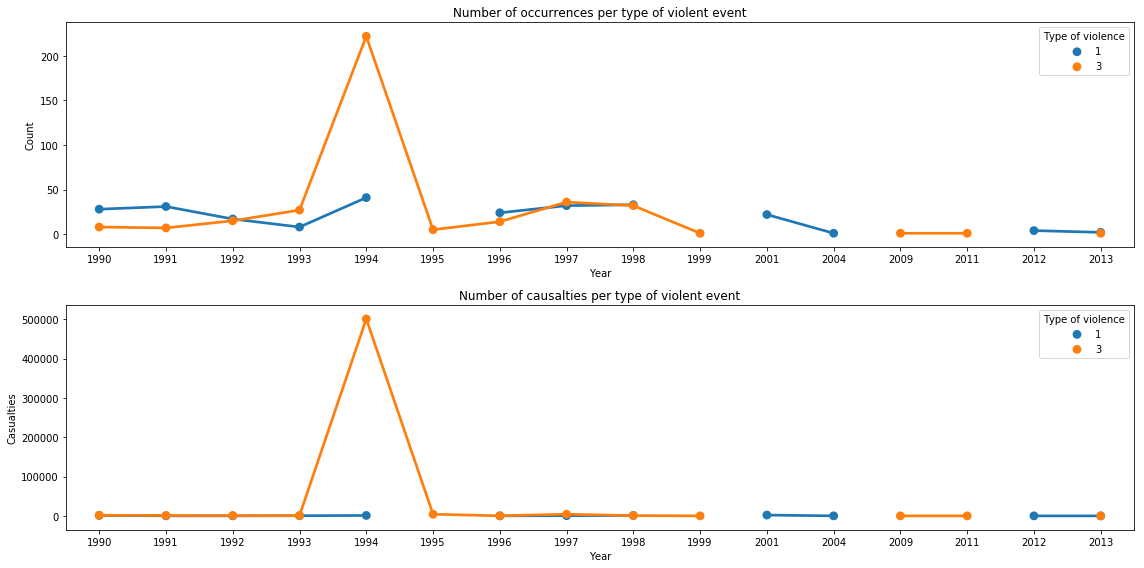

In [142]:
plot_conflicts(country_conflicts('Rwanda', 'ea'))

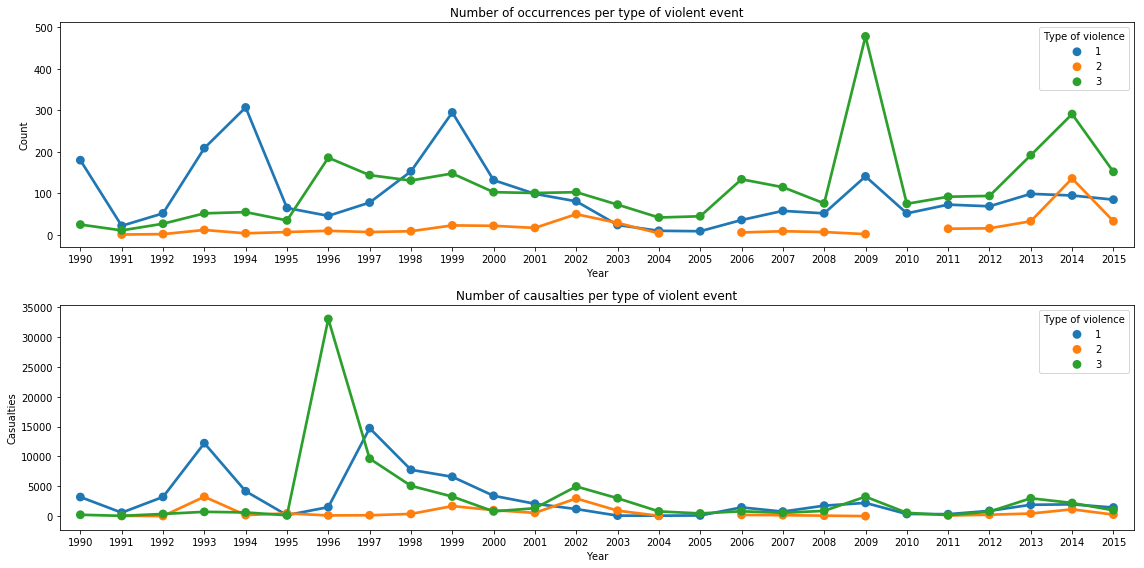

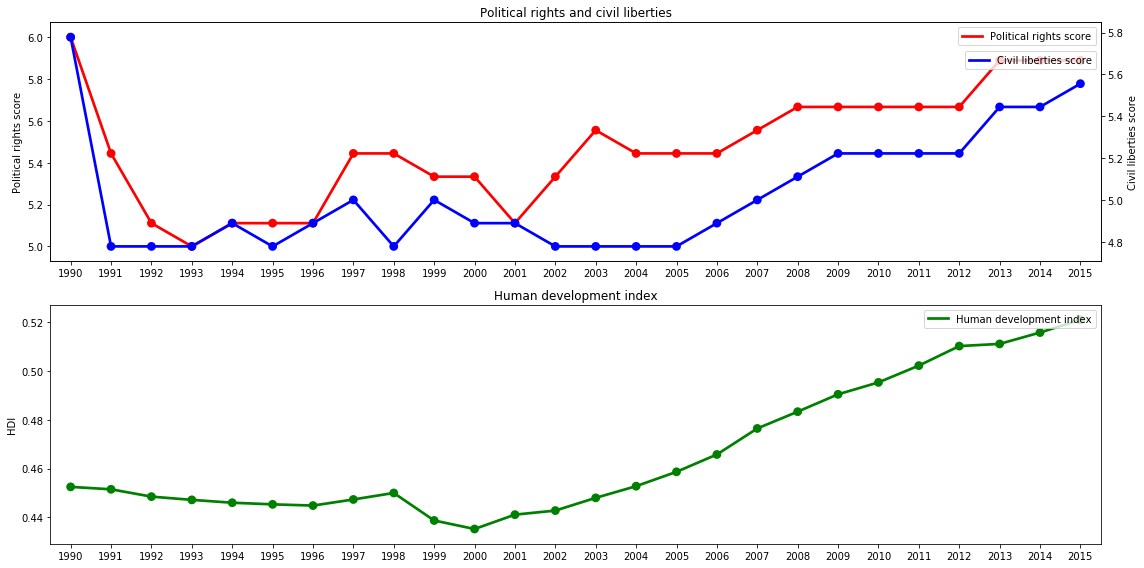

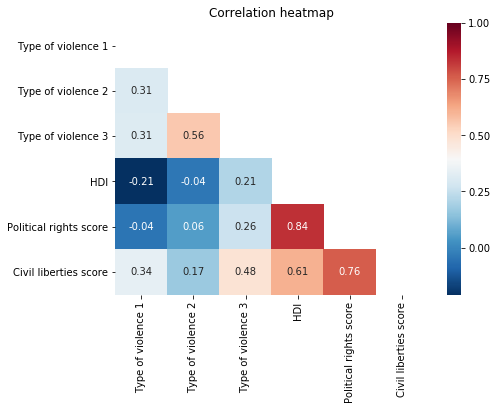

In [143]:
ca_conflicts = region_conflicts('ca')
ca_indicators = region_indicators('ca')
ca_correlation_data = region_correlation_data('ca')

plot_conflicts(ca_conflicts)
plot_indicators(ca_indicators)
plot_correlation(ca_correlation_data)

#### Maps

In [144]:
ca_conflicts_map = map_conflicts_per_country('ca')
ca_indicators_map = map_indicators_per_country('ca')

save_map(ca_conflicts_map, 'ca_conflicts.html')
save_map(ca_indicators_map, 'ca_indicators.html')

IFrame(src=map_path('ca_conflicts.html'), width=900, height=500)
IFrame(src=map_path('ca_indicators.html'), width=900, height=500)

### Zimbabwe - case study

Zimbabwe is a landlocked eastern African country bordered by Zambia in the north, Mozambique in the east, Botswana in the west and South Africa in the south. Although once seen as regional economic leader, since 2000 Zimbabwe has struggled to feed its own people due to severe droughts and the effects of a land reform program which saw the seizure of white-owned farms redistributed to landless black Zimbabweans which led to sharp falls in production.

Cash-strapped and impoverished, Zimbabwe's economy faces severe challenges. Unemployment and poverty are endemic and political strife and repression commonplace. Many Zimbabweans have left the country in search of work in South Africa.

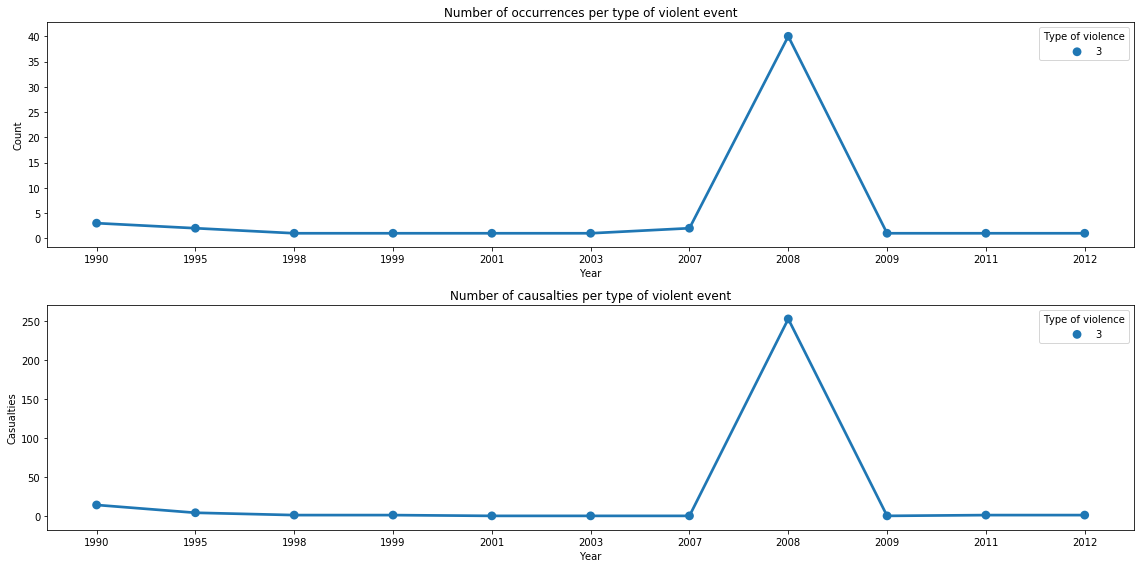

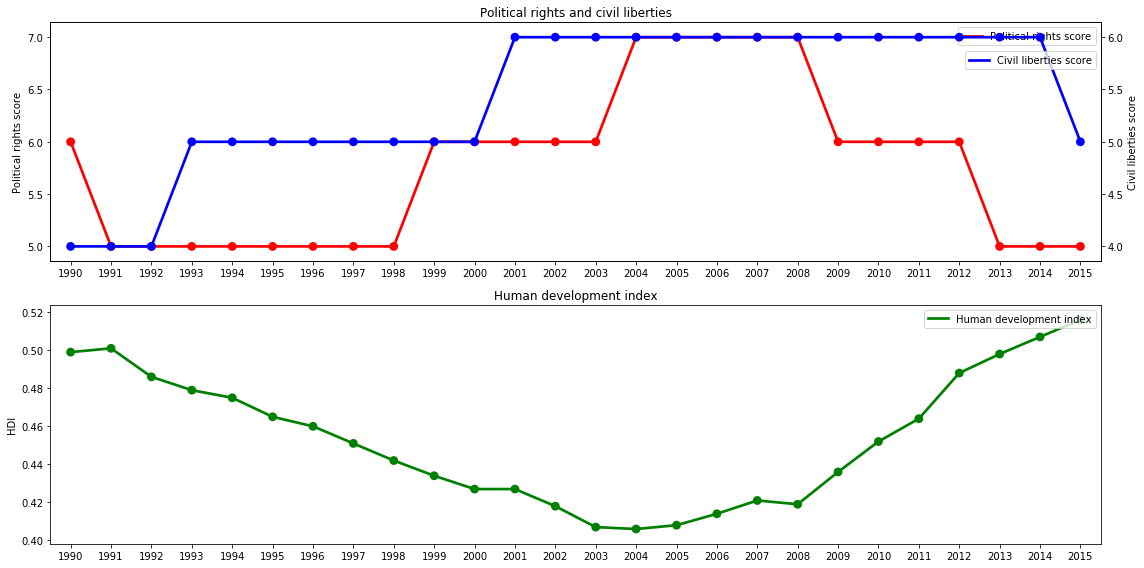

In [145]:
plot_conflicts(country_conflicts('Zimbabwe', 'ea'))
plot_indicators(country_indicators('Zimbabwe', 'ea'))

In [146]:
zimbabwe = df_ea[df_ea.country == 'Zimbabwe']
zimbabwe[['type_of_violence','side_a','side_b']].head(15)

,type_of_violence,side_a,side_b
9564,3,Renamo,Civilians
9772,3,Renamo,Civilians
9784,3,Renamo,Civilians
9789,3,Renamo,Civilians
9790,3,Renamo,Civilians
12659,3,Government of Zimbabwe (Rhodesia),Civilians
12693,3,Government of Zimbabwe (Rhodesia),Civilians
15528,3,Government of Zimbabwe (Rhodesia),Civilians
15531,3,Government of Zimbabwe (Rhodesia),Civilians
15539,3,Government of Zimbabwe (Rhodesia),Civilians


From the plots depicting occurrences of violent events and number of casualties sustained, we observe that throughout the period of interest only one-sided violent events were reported. Furthermore, a closer look at the data with focus on parties engaged in the conflict shows that all of the reported events include Zambia’s government as the aggressor directly, or indirectly through [Renamo](https://en.wikipedia.org/wiki/RENAMO). Renamo is Mozambican National Resistance, a militant organization and political movement in Mozambique sponsored by the Rhodesian Central Intelligence Organization.

Both numbers of violent events and casualties sustained experiences peak in the year of 2008, during the presidential and parliamentary elections that saw violent clashes between supporters of incumbent president Robert Mugabe, and his challenger Morgan Tsvangirai. Even though challenger candidate Morgan Tsvangirai secured small lead in the first round of votes for president, he backed out off the run-off round complaining of intimidation and violence against his supporters. This move has been reported as a president Mugabe’s successful attempt to thwart political opposition that secured him the victory in the presidential race. Furthermore, these elections will prove to be the start of the decline in Zimbabweans civil liberties that will continue until 2015.

Human development indexes steady decline from the year 1991 to 2000 reflects a significant decline in the Zimbabwean population’s health, where by 1997 an estimated 25% of the population had been infected by HIV in a pandemic that was affecting most of southern Africa. 
In 2000, the government pressed ahead with its ‘Fast Track Land Reform’ program, a policy involving compulsory land acquisition aimed at redistributing land from the minority white population to the majority black population. Confiscations of white farmland, continuous droughts, and a serious drop in external finance and other supports led to a sharp decline in agricultural exports, which were traditionally the country's leading export-producing sector. Some 58,000 independent black farmers have since experienced limited success in reviving the gutted cash crop sectors through efforts on a smaller scale. President Mugabe and the ZANU-PF party leadership found themselves beset by a wide range of international sanctions. In 2002, the nation was suspended from the Commonwealth of Nations due to the reckless farm seizures and blatant election tampering.

The Zimbabwe Democracy and Economic Recovery Act of 2001 (ZDERA) went into effect in 2002. The Zimbabwe Democracy and Economic Recovery Act is an act passed by the United States Congress sanctioned to provide for a transition to democracy and to promote economic recovery in Zimbabwe. This as a result saw Zimbabwe’s human development index to increase steadily from 2002, with slight dip in the year 2008 due to aforementioned unrests during presidential and parliamentary elections.